In [1]:
from urllib.request import urlopen
from IPython.display import SVG
import matplotlib.pyplot as plt
from rdkit import Chem
from tqdm import tqdm
import pandas as pd
import xlsxwriter
import argparse
import pickle
import numpy as np
import json
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import visualizer as visualizer
import utils as utils
import handle_network as hn
import fragmentation_py as fragmentation_py
import library_downloader as library_downloader
import SiteLocator as modSite
import alignment as alignment
from Compound_n import Compound
from ModificationSiteLocator import ModificationSiteLocator

library ="BERKELEY-LAB"
if not os.path.exists( os.path.join("../data/libraries", library)):
    url = "https://gnps-external.ucsd.edu/gnpslibrary/" + library + ".json"
    location = "../data/libraries/" + library + "/"
    library_downloader.download(url, location, 0.5, 0.1)

with open(os.path.join("../data/libraries", library, "data_dict_filtered.pkl"), "rb") as f:
    data_dict_filtered = pickle.load(f)

# load matches
with open(os.path.join("../data/libraries", library, "matches.pkl"), "rb") as f:
    matches = pickle.load(f)

# load cachedStructures_filtered
with open(os.path.join("../data/libraries", library, "cachedStructures.pkl"), "rb") as f:
    cachedStructures_filtered = pickle.load(f)

In [7]:

def is_good(main, modified):
    molData = data_dict_filtered[main]
    modifiedData = data_dict_filtered[modified]
    molMol = cachedStructures_filtered[main]
    modifiedMol = cachedStructures_filtered[modified]

    if molData["Adduct"] != modifiedData["Adduct"] or molData["Adduct"] != "M+H":
        return -7

    if abs(float(molData["Precursor_MZ"]) - float(modifiedData["Precursor_MZ"])) < 20:
        return -1
    matchedPeaks = alignment.handle_alignment(molData, modifiedData)['matchedPeaks']
    if len(matchedPeaks) < 6:
        return -2
    
    if not modifiedMol.HasSubstructMatch(molMol):
        return -3
    
    main_c = Compound(molData, molMol)
    modified_c = Compound(modifiedData, modifiedMol)

    before = copy.deepcopy(main_c.peak_fragments_map)
    helperDirectory = os.path.join("../data/libraries", library, "nf_output/fragmentationtrees/")
    try:
        with open(os.path.join(helperDirectory, main + "_fragmentationtree.json")) as f:
            molSirius = json.load(f)
    except FileNotFoundError:
        return -4
    main_c.apply_sirius(molSirius)
    flag = False
    for i, peak in enumerate(main_c.peaks):
        if (len(main_c.peak_fragments_map[i]) == 1 and len(before[i]) != 1):
            flag = True
            break
    
    if flag:
        return -5
    
    site_locator = ModificationSiteLocator(main_c, modified_c)
    true_modif_loc = utils.calculateModificationSites(modifiedMol, molMol, False)
    print(true_modif_loc)
    score = site_locator.calculate_score(true_modif_loc, "temp")
    if score < 0.8:
        return -6
    print(score)
    
    return 1
    

In [8]:
diff = 0
peak_count = 0
not_sub = 0
while (True):
    print('.', end='')
    try:
        ex = matches[1].pop()
    except:
        break
    m0 = ex[1]
    m1 = ex[0]
    temp = is_good(m0, m1)
    if temp > 0:
        print("temp", temp)
        break
    else:
        if temp == -1:
            diff += 1
        elif temp == -2:
            peak_count += 1
        elif temp == -3:
            not_sub += 1

print (not_sub, peak_count, diff)

molData = data_dict_filtered[m0]
modifiedData = data_dict_filtered[m1]
molMol = cachedStructures_filtered[m0]
modifiedMol = cachedStructures_filtered[m1]

print(molData["Precursor_MZ"], modifiedData["Precursor_MZ"])

..............................................................[5]
..........[5]
...................................[12]
[1.]
temp 1
0 4 27
337.071 427.118


In [2]:
#force m1, m2
m0 = "CCMSLIB00010122735"
m1 = "CCMSLIB00010123634"

In [124]:
print(m0, m1)
print(hn.generate_usi(library, m0))
print(hn.generate_usi(library, m1))


CCMSLIB00010122735 CCMSLIB00010123634
mzspec:GNPS:CCMSLIB00010122735:accession:BERKELEY-LAB
mzspec:GNPS:CCMSLIB00010123634:accession:BERKELEY-LAB


True


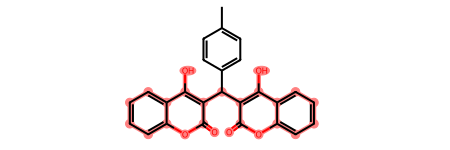

In [3]:
molData = data_dict_filtered[m0]
modifiedData = data_dict_filtered[m1]
molMol = cachedStructures_filtered[m0]
modifiedMol = cachedStructures_filtered[m1]
main_c = Compound(molData, molMol)
modified_c = Compound(modifiedData, modifiedMol)
site_locator = ModificationSiteLocator(main_c, modified_c)
true_modif_loc = utils.calculateModificationSites(modifiedMol, molMol, False)
print(modifiedMol.HasSubstructMatch(molMol))
modifiedMol.GetSubstructMatch(molMol)
modifiedMol

203.082275 100.0


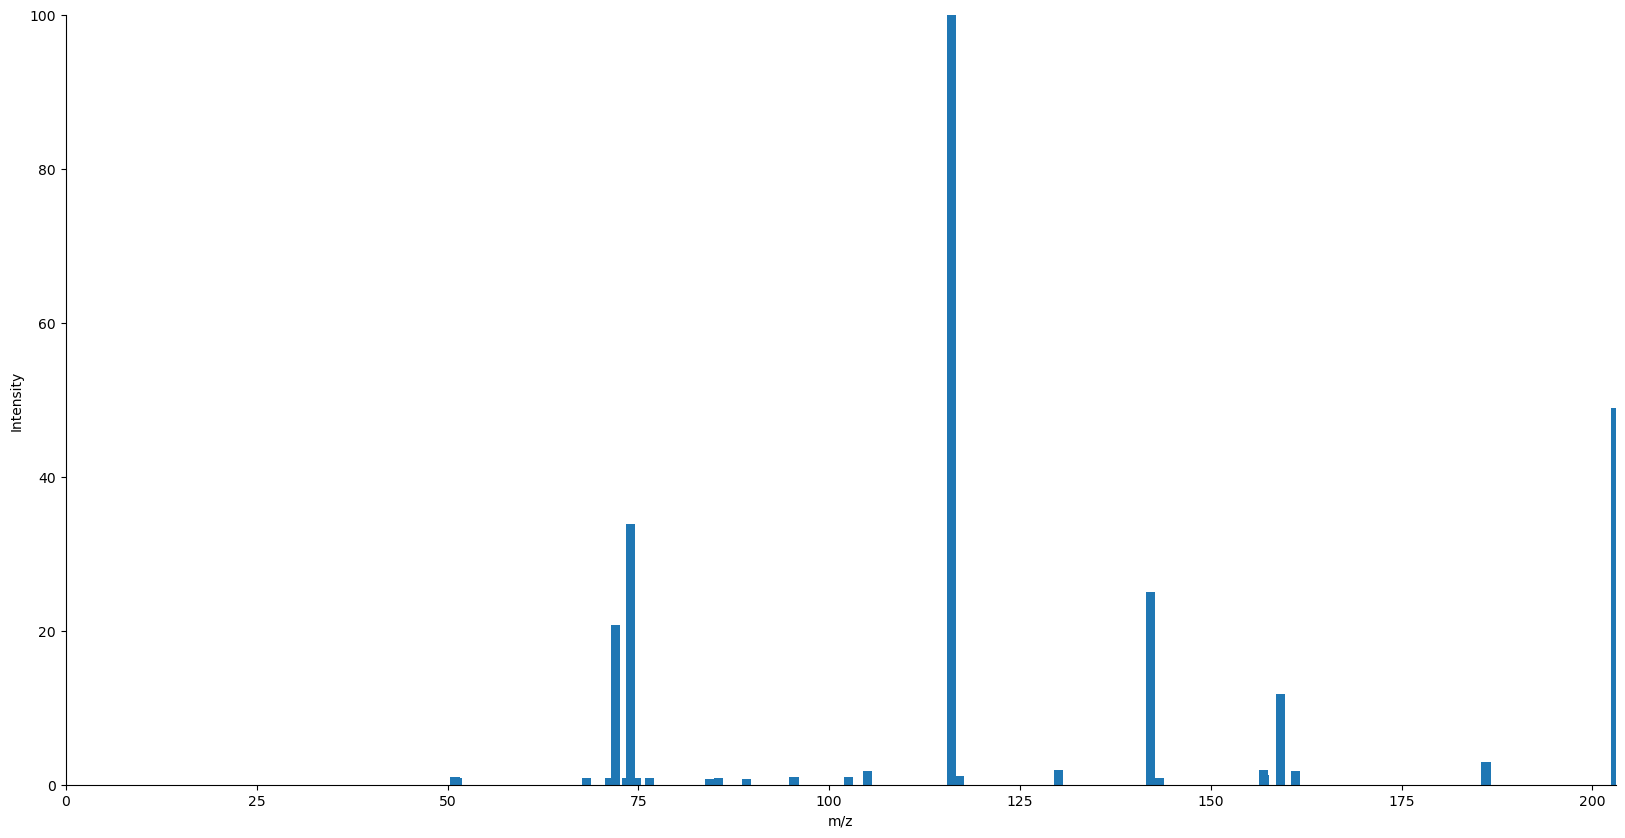

In [84]:
# draw peaks
def draw_peaks(data, name):
    plt.figure(figsize=(20, 10))
    mz = [data[i][0] for i in range(len(data))]
    intensity = [data[i][1] for i in range(len(data))]
    intensity = np.array(intensity)
    intensity = intensity / max(intensity) * 100
    plt.bar(mz, intensity, width=1.2)
    # remove borders
    plt.xlim(0, max(mz))
    plt.ylim(0, max(intensity))

    #remove black borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.xlabel("m/z")
    plt.ylabel("Intensity")

    # make plot transparent
    plt.gca().patch.set_alpha(0)

    print(max(mz), max(intensity))
    
    plt.savefig("./images/" + name + ".png", bbox_inches='tight', transparent=True)
    plt.show()

draw_peaks(json.loads(molData["peaks_json"]), "mol")

358.892822 100.0


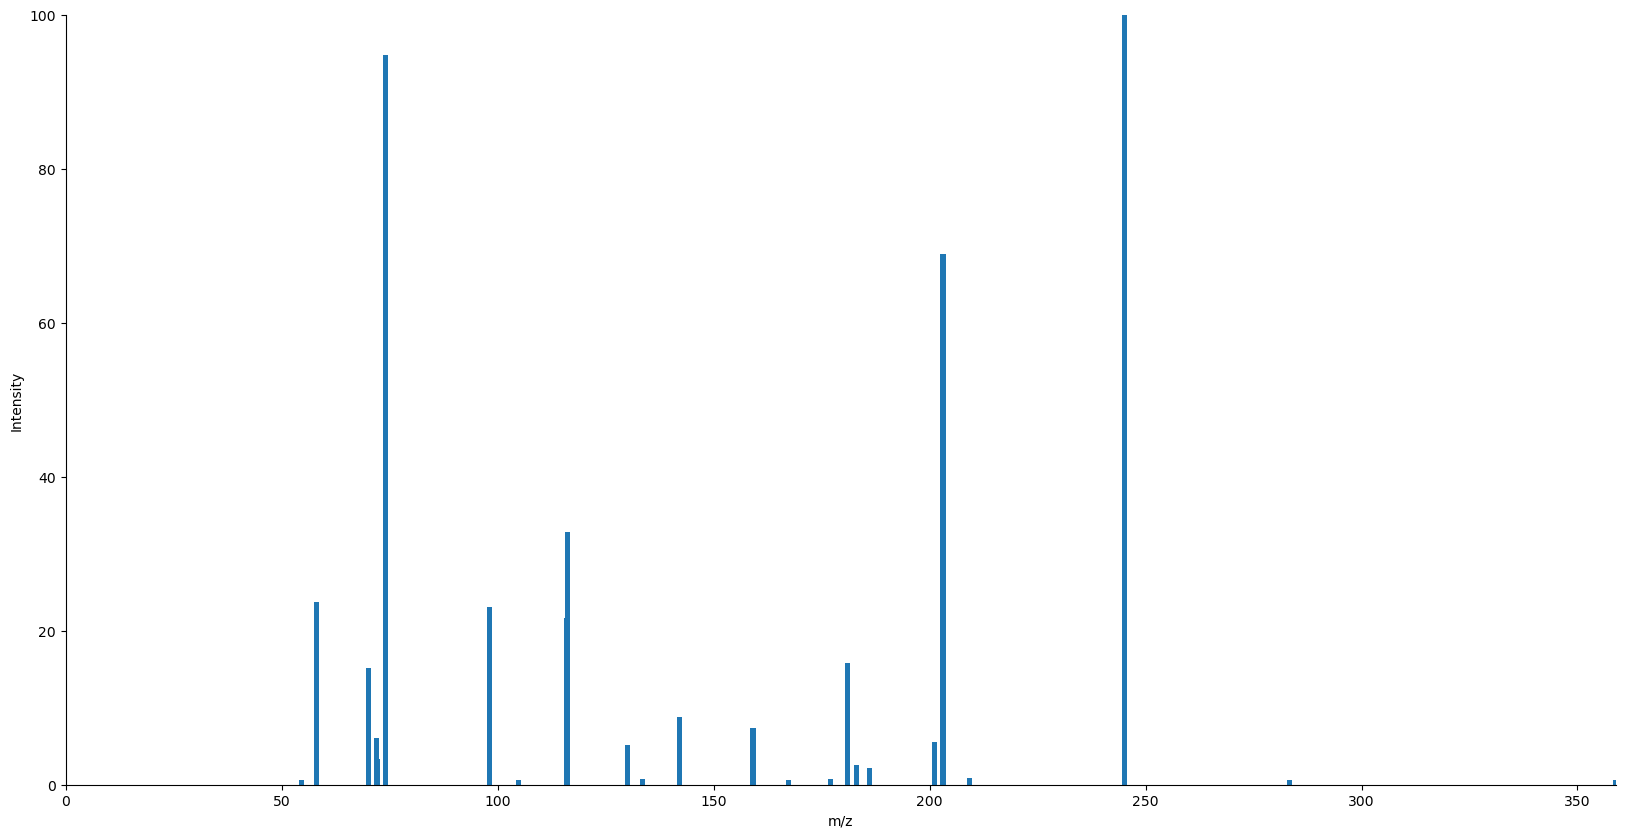

In [85]:
draw_peaks(json.loads(modifiedData["peaks_json"]), "modified")

In [88]:
import cairosvg
# draw mol png
def draw_mol(mol, name):
    mol = Chem.MolFromSmiles(mol)
    drawer = Chem.Draw.rdMolDraw2D.MolDraw2DSVG(400, 400)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace("svg:", "")
    with open("./images/" + name + ".svg", "w") as f:
        f.write(svg)
    cairosvg.svg2png(url="./images/" + name + ".svg", write_to="./images/" + name + ".png", background_color="transparent")

draw_mol(molData["Smiles"], "molMol")

draw allignment

[-0.8, -0.6, -0.4, -0.2, 0.0, 0.1, 0.30000000000000004, 0.5, 0.7, 0.9]
[0.8, 0.6, 0.4, 0.2, 0.0, 0.0, 0.2, 0.4, 0.6, 0.8]


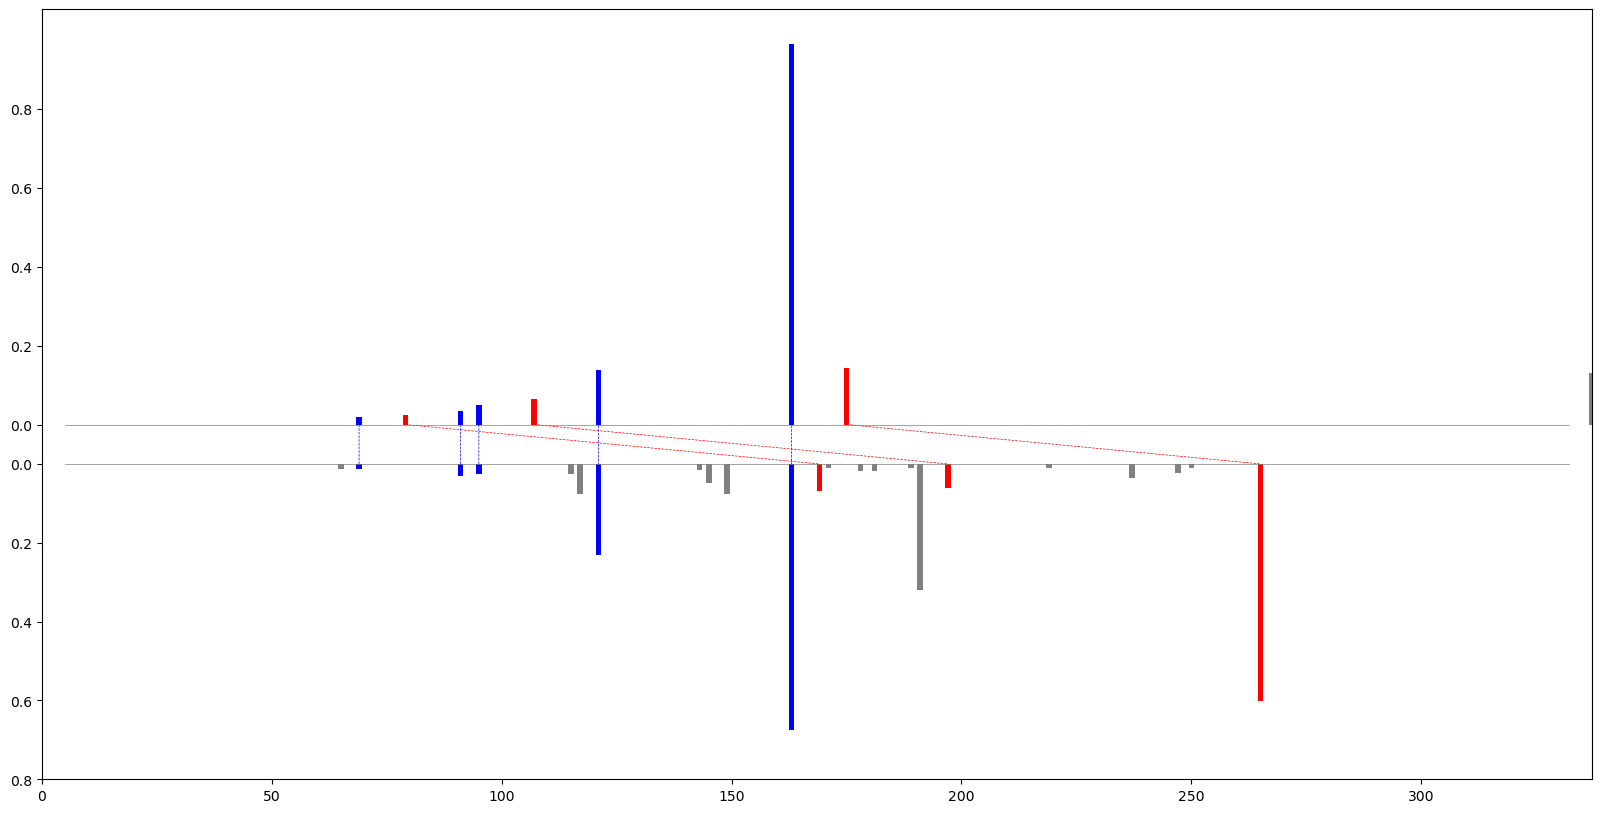

In [7]:
res = visualizer.draw_alignment(site_locator.main_compound.peaks, site_locator.modified_compound.peaks, site_locator.matched_peaks)

draw hitmap

[0.06666667 0.04444444 0.         0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.06666667 0.04444444 0.08888889
 0.11111111 0.08888889 0.06666667 0.04444444 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.         0.04444444
 0.06666667] 0.1111111111111111 1
[1.]


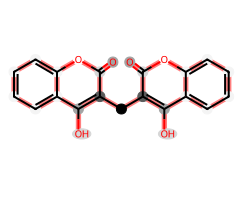

In [10]:
scores = site_locator.generate_probabilities()
print(scores, max(scores), np.count_nonzero(scores == max(scores)))
print(site_locator.calculate_score(true_modif_loc, "temp"))
SVG(visualizer.highlightScores(molMol, scores))